In [1]:
import sys
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.applications import resnet50
import pandas as pd
import numpy as np
import os
import cv2

In [2]:
labels = pd.read_csv('Data/train_label.csv')
labels.head()

,Unnamed: 0,id,Type
0,0,distribute_40,distribute
1,1,distribute_41,distribute
2,2,distribute_42,distribute
3,3,distribute_43,distribute
4,4,distribute_44,distribute


In [3]:
labels['Type'].value_counts()

distribute    360
matrix        360
ineq          360
integral      360
series        360
sqrt          360
limit         360
Name: Type, dtype: int64

In [4]:
sample = pd.read_csv('Data/sample_submission.csv')
sample.head()

,id,distribute,ineq,integral,limit,matrix,series,sqrt
0,distribute_40,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857
1,distribute_41,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857
2,distribute_42,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857
3,distribute_43,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857
4,distribute_44,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857


In [5]:
num_train_images = 2520  # we choose 3300 images for this assignment. It works for a machine having 8Gb Ram. You can adjust it if your Ram is different. 
split_point = 2240 # split the data into training data [0:3000] and val data [3000:]
print('num_train_images:', num_train_images)
types = sample.columns[1:]
print('Types:', types)
num_classes = len(types)
print('num_classes:', num_classes)

num_train_images: 2520
Types: Index(['distribute', 'ineq', 'integral', 'limit', 'matrix', 'series', 'sqrt'], dtype='object')
num_classes: 7


In [6]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

img_width = 224

def get_image(filename):
    ########################################################################
    # TODO: Your code here...
    ########################################################################
    original = load_img(filename, target_size=(224,224))
    numpy_image = img_to_array(original)
    image_batch = np.expand_dims(numpy_image, axis=0)
    return image_batch[0]

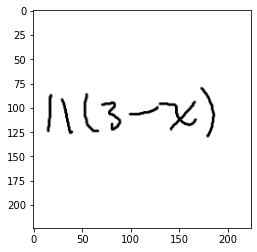

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

image = get_image('Data/train/distribute_41.png')
plt.imshow(np.uint8(image))
plt.show()

In [9]:
x_train = np.zeros((num_train_images, img_width, img_width, 3), dtype=np.uint8)
y_train = np.zeros((num_train_images, num_classes), dtype=np.uint8)

count = 0

for i in range(num_train_images):
    x_train[i] = get_image('Data/train/%s.png' % labels['id'][i])
    pos_arrays = (types == labels['Type'][i]).nonzero() # recall that types is the array of classes
    pos = pos_arrays[0][0]
    y_train[i][pos] = 1
    count += 1
    if(count % 1000 == 0): print(count, 'images loaded')

1000 images loaded
2000 images loaded


### Resnet with MeanSquaredError

In [33]:
from tensorflow.keras.applications import resnet50
resnet_mse_x_train = resnet50.preprocess_input(x_train.copy())
resnet_mse_model = resnet50.ResNet50(weights='imagenet', include_top=False)
resnet_mse_features = resnet_mse_model.predict(resnet_mse_x_train, batch_size=64, verbose=1)
print(resnet_mse_features.shape)

40/40 [==============================] - 197s 5s/step
(2520, 7, 7, 2048)


In [34]:
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout, Activation, BatchNormalization

inputs = Input(shape = (7, 7, 2048)) # to take 7 x 7 x 2048 images
x = GlobalAveragePooling2D()(inputs) # to convert to 2048 feagures
print(x.shape)
x = Dropout(0.5)(x) # add a dropout layer
x = Dense(500)(x) # add a dense layer, but not adding activation so that we can add batch-norm first
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Dropout(0.5)(x) # add a dropout layer
# Softmax layer to the output classes
predictions = Dense(num_classes, activation='softmax')(x) # arg1 is: units = dimensionality of the output space.
print(predictions.shape)

(None, 2048)
(None, 7)


In [35]:
from tensorflow.keras.models import Model

model_mse = Model(inputs=inputs, outputs=predictions) # specify what is network input, and what is network output
model_mse.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 7, 7, 2048)]      0         
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_4 (Dropout)         (None, 2048)              0         
                                                                 
 dense_4 (Dense)             (None, 500)               1024500   
                                                                 
 batch_normalization_2 (Batc  (None, 500)              2000      
 hNormalization)                                                 
                                                                 
 activation_2 (Activation)   (None, 500)               0   

In [36]:
model_mse.compile(loss='MeanSquaredError', optimizer="sgd", metrics=['accuracy'])

In [37]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',  patience=3, verbose=1)
# stop if loss does not improve for 3 iterations

model_mse.fit(resnet_mse_features[:split_point], y_train[:split_point], batch_size=128, epochs=30, 
              validation_data=(resnet_mse_features[split_point:], y_train[split_point:]), callbacks=[early_stop], verbose=1)


Epoch 1/30
18/18 [==============================] - 2s 49ms/step - loss: 0.1485 - accuracy: 0.1415 - val_loss: 0.1929 - val_accuracy: 0.0000e+00
Epoch 2/30
18/18 [==============================] - 1s 40ms/step - loss: 0.1457 - accuracy: 0.1647 - val_loss: 0.1797 - val_accuracy: 0.0000e+00
Epoch 3/30
18/18 [==============================] - 1s 44ms/step - loss: 0.1460 - accuracy: 0.1513 - val_loss: 0.1690 - val_accuracy: 0.0000e+00
Epoch 4/30
18/18 [==============================] - 1s 40ms/step - loss: 0.1463 - accuracy: 0.1536 - val_loss: 0.1603 - val_accuracy: 0.0036
Epoch 5/30
18/18 [==============================] - 1s 36ms/step - loss: 0.1437 - accuracy: 0.1670 - val_loss: 0.1545 - val_accuracy: 0.0036
Epoch 6/30
18/18 [==============================] - 1s 36ms/step - loss: 0.1428 - accuracy: 0.1768 - val_loss: 0.1496 - val_accuracy: 0.0071
Epoch 7/30
18/18 [==============================] - 1s 45ms/step - loss: 0.1432 - accuracy: 0.1688 - val_loss: 0.1458 - val_accuracy: 0.0107
E

In [38]:
model_mse.save('model_mse.h5') 

In [39]:
Test_prediction = []
for files in os.listdir('./Data/Test_2'):

    if files== 'desktop.ini':
        pass
    else:    
        test_img = get_image(f'./Data/Test_2/{files}')
        image_batch = np.expand_dims(test_img, axis=0)
        image_batch = np.copy(image_batch)
        image_batch = resnet50.preprocess_input(image_batch)
        feature_input = resnet_mse_model.predict(image_batch)
        predictions = model_mse.predict(feature_input)
        pos = np.argmax(predictions)
        Test_prediction.append(pos)


In [40]:
y_test = pd.read_excel(r'./Data/test_2_label.xlsx',usecols=[1,1])
y_test = y_test.to_numpy()
y_test = np.squeeze(y_test)

In [41]:
test_acc = (Test_prediction == y_test).mean()
print('Test accuracy: ', test_acc)

Test accuracy:  0.2857142857142857


### Resnet with MeanAbsoluteError

In [20]:
resnet_mae_x_train = resnet50.preprocess_input(x_train.copy())
resnet_mae_model = resnet50.ResNet50(weights='imagenet', include_top=False)
resnet_mae_features = resnet_mae_model.predict(resnet_mae_x_train, batch_size=64, verbose=1)
print(resnet_mae_features.shape)

40/40 [==============================] - 199s 5s/step
(2520, 7, 7, 2048)


In [21]:
inputs = Input(shape = (7, 7, 2048)) # to take 7 x 7 x 2048 images
x = GlobalAveragePooling2D()(inputs) # to convert to 2048 feagures
print(x.shape)
x = Dropout(0.5)(x) # add a dropout layer
x = Dense(500)(x) # add a dense layer, but not adding activation so that we can add batch-norm first
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Dropout(0.5)(x) # add a dropout layer
# Softmax layer to the output classes
predictions = Dense(num_classes, activation='softmax')(x) # arg1 is: units = dimensionality of the output space.
print(predictions.shape)


(None, 2048)
(None, 7)


In [22]:
model_mae = Model(inputs=inputs, outputs=predictions) # specify what is network input, and what is network output
model_mae.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 7, 7, 2048)]      0         
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_2 (Dropout)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 500)               1024500   
                                                                 
 batch_normalization_1 (Batc  (None, 500)              2000      
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 500)               0   

In [23]:
model_mae.compile(loss='MeanAbsoluteError', optimizer="adam", metrics=['accuracy'])

In [24]:
early_stop = EarlyStopping(monitor='val_loss',  patience=3, verbose=1)
# stop if loss does not improve for 3 iterations

model_mae.fit(resnet_mae_features[:split_point], y_train[:split_point], batch_size=128, epochs=30, 
              validation_data=(resnet_mae_features[split_point:], y_train[split_point:]), callbacks=[early_stop], verbose=1)


Epoch 1/30
18/18 [==============================] - 1s 43ms/step - loss: 0.1599 - accuracy: 0.4875 - val_loss: 0.2856 - val_accuracy: 0.0000e+00
Epoch 2/30
18/18 [==============================] - 1s 37ms/step - loss: 0.0974 - accuracy: 0.7031 - val_loss: 0.2856 - val_accuracy: 0.0000e+00
Epoch 3/30
18/18 [==============================] - 1s 37ms/step - loss: 0.0805 - accuracy: 0.7464 - val_loss: 0.2855 - val_accuracy: 0.0000e+00
Epoch 4/30
18/18 [==============================] - 1s 37ms/step - loss: 0.0730 - accuracy: 0.7746 - val_loss: 0.2853 - val_accuracy: 0.0000e+00
Epoch 5/30
18/18 [==============================] - 1s 37ms/step - loss: 0.0649 - accuracy: 0.8013 - val_loss: 0.2844 - val_accuracy: 0.0000e+00
Epoch 6/30
18/18 [==============================] - 1s 37ms/step - loss: 0.0582 - accuracy: 0.8237 - val_loss: 0.2824 - val_accuracy: 0.0000e+00
Epoch 7/30
18/18 [==============================] - 1s 39ms/step - loss: 0.0559 - accuracy: 0.8295 - val_loss: 0.2772 - val_accura

In [25]:
model_mae.save('model_mae.h5') # you may try load_model.ipynb to see how it's loaded (not required)

In [26]:
Test_prediction1 = []
for files in os.listdir('./Data/Test_2'):

    if files== 'desktop.ini':
        pass
    else:    
        test_img = get_image(f'./Data/Test_2/{files}')
        image_batch = np.expand_dims(test_img, axis=0)
        image_batch = np.copy(image_batch)
        image_batch = resnet50.preprocess_input(image_batch)
        feature_input = resnet_mae_model.predict(image_batch)
        predictions = model_mae.predict(feature_input)
        pos = np.argmax(predictions)
        Test_prediction1.append(pos)


In [27]:
test_acc = (Test_prediction1 == y_test).mean()
print('Test accuracy: ', test_acc)


Test accuracy:  0.7678571428571429


### Resnet with Hinge

In [51]:
resnet_hinge_x_train = resnet50.preprocess_input(x_train.copy())
resnet_hinge_model = resnet50.ResNet50(weights='imagenet', include_top=False)
resnet_hinge_features = resnet_hinge_model.predict(resnet_hinge_x_train, batch_size=64, verbose=1)
print(resnet_hinge_features.shape)

40/40 [==============================] - 210s 5s/step
(2520, 7, 7, 2048)


In [52]:
inputs = Input(shape = (7, 7, 2048)) # to take 7 x 7 x 2048 images
x = GlobalAveragePooling2D()(inputs) # to convert to 2048 feagures
print(x.shape)
x = Dropout(0.5)(x) # add a dropout layer
x = Dense(500)(x) # add a dense layer, but not adding activation so that we can add batch-norm first
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Dropout(0.5)(x) # add a dropout layer
# Softmax layer to the output classes
predictions = Dense(num_classes, activation='softmax')(x) # arg1 is: units = dimensionality of the output space.
print(predictions.shape)

(None, 2048)
(None, 7)


In [53]:
model_hinge = Model(inputs=inputs, outputs=predictions) # specify what is network input, and what is network output
model_hinge.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 7, 7, 2048)]      0         
                                                                 
 global_average_pooling2d_4   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_8 (Dropout)         (None, 2048)              0         
                                                                 
 dense_8 (Dense)             (None, 500)               1024500   
                                                                 
 batch_normalization_4 (Batc  (None, 500)              2000      
 hNormalization)                                                 
                                                                 
 activation_4 (Activation)   (None, 500)               0   

In [54]:
model_hinge.compile(loss='Hinge', optimizer="adam", metrics=['accuracy'])

In [55]:
early_stop = EarlyStopping(monitor='val_loss',  patience=3, verbose=1)
# stop if loss does not improve for 3 iterations

model_hinge.fit(resnet_hinge_features[:split_point], y_train[:split_point], batch_size=128, epochs=30, 
              validation_data=(resnet_hinge_features[split_point:], y_train[split_point:]), callbacks=[early_stop], verbose=1)


Epoch 1/30
18/18 [==============================] - 1s 38ms/step - loss: 1.0194 - accuracy: 0.4661 - val_loss: 1.1386 - val_accuracy: 0.0000e+00
Epoch 2/30
18/18 [==============================] - 1s 30ms/step - loss: 0.9585 - accuracy: 0.6741 - val_loss: 1.1118 - val_accuracy: 0.0679
Epoch 3/30
18/18 [==============================] - 1s 31ms/step - loss: 0.9379 - accuracy: 0.7500 - val_loss: 0.9989 - val_accuracy: 0.5321
Epoch 4/30
18/18 [==============================] - 1s 35ms/step - loss: 0.9262 - accuracy: 0.7888 - val_loss: 0.9225 - val_accuracy: 0.7821
Epoch 5/30
18/18 [==============================] - 1s 31ms/step - loss: 0.9174 - accuracy: 0.8174 - val_loss: 0.8923 - val_accuracy: 0.8929
Epoch 6/30
18/18 [==============================] - 1s 32ms/step - loss: 0.9128 - accuracy: 0.8353 - val_loss: 0.8864 - val_accuracy: 0.9071
Epoch 7/30
18/18 [==============================] - 1s 32ms/step - loss: 0.9083 - accuracy: 0.8464 - val_loss: 0.8762 - val_accuracy: 0.9429
Epoch 8/3

In [56]:
model_hinge.save('model_hinge.h5') # you may try load_model.ipynb to see how it's loaded (not required)

In [57]:
Test_prediction6 = []
for files in os.listdir('./Data/Test_2'):

    if files== 'desktop.ini':
        pass
    else:    
        test_img = get_image(f'./Data/Test_2/{files}')
        image_batch = np.expand_dims(test_img, axis=0)
        image_batch = np.copy(image_batch)
        image_batch = resnet50.preprocess_input(image_batch)
        feature_input = resnet_hinge_model.predict(image_batch)
        predictions = model_hinge.predict(feature_input)
        pos = np.argmax(predictions)
        Test_prediction6.append(pos)


In [58]:
test_acc = (Test_prediction6 == y_test).mean()
print('Test accuracy: ', test_acc)


Test accuracy:  0.75


### Resnet with SquaredHinge

In [59]:
from tensorflow.keras.applications import resnet50
resnet_sh_x_train = resnet50.preprocess_input(x_train.copy())
resnet_sh_model = resnet50.ResNet50(weights='imagenet', include_top=False)
resnet_sh_features = resnet_sh_model.predict(resnet_sh_x_train, batch_size=64, verbose=1)
print(resnet_sh_features.shape)


40/40 [==============================] - 208s 5s/step
(2520, 7, 7, 2048)


In [60]:
inputs = Input(shape = (7, 7, 2048)) # to take 7 x 7 x 2048 images
x = GlobalAveragePooling2D()(inputs) # to convert to 2048 feagures
print(x.shape)
x = Dropout(0.5)(x) # add a dropout layer
x = Dense(500)(x) # add a dense layer, but not adding activation so that we can add batch-norm first
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Dropout(0.5)(x) # add a dropout layer
# Softmax layer to the output classes
predictions = Dense(num_classes, activation='softmax')(x) # arg1 is: units = dimensionality of the output space.
print(predictions.shape)


(None, 2048)
(None, 7)


In [61]:
model_sh = Model(inputs=inputs, outputs=predictions) # specify what is network input, and what is network output
model_sh.summary()


Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 7, 7, 2048)]      0         
                                                                 
 global_average_pooling2d_5   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_10 (Dropout)        (None, 2048)              0         
                                                                 
 dense_10 (Dense)            (None, 500)               1024500   
                                                                 
 batch_normalization_5 (Batc  (None, 500)              2000      
 hNormalization)                                                 
                                                                 
 activation_5 (Activation)   (None, 500)               0   

In [64]:
model_sh.compile(loss='SquaredHinge', optimizer="adam", metrics=['accuracy'])

In [65]:
early_stop = EarlyStopping(monitor='val_loss',  patience=3, verbose=1)
# stop if loss does not improve for 3 iterations

model_sh.fit(resnet_sh_features[:split_point], y_train[:split_point], batch_size=128, epochs=30, 
              validation_data=(resnet_sh_features[split_point:], y_train[split_point:]), callbacks=[early_stop], verbose=1)


Epoch 1/30
18/18 [==============================] - 1s 39ms/step - loss: 1.1149 - accuracy: 0.4897 - val_loss: 1.2486 - val_accuracy: 0.2500
Epoch 2/30
18/18 [==============================] - 1s 37ms/step - loss: 1.0189 - accuracy: 0.7004 - val_loss: 0.9309 - val_accuracy: 0.8679
Epoch 3/30
18/18 [==============================] - 1s 53ms/step - loss: 0.9825 - accuracy: 0.7723 - val_loss: 0.9201 - val_accuracy: 0.8821
Epoch 4/30
18/18 [==============================] - 1s 44ms/step - loss: 0.9655 - accuracy: 0.8071 - val_loss: 0.8980 - val_accuracy: 0.9214
Epoch 5/30
18/18 [==============================] - 1s 43ms/step - loss: 0.9550 - accuracy: 0.8286 - val_loss: 0.8860 - val_accuracy: 0.9464
Epoch 6/30
18/18 [==============================] - 1s 40ms/step - loss: 0.9435 - accuracy: 0.8540 - val_loss: 0.8900 - val_accuracy: 0.9429
Epoch 7/30
18/18 [==============================] - 1s 45ms/step - loss: 0.9384 - accuracy: 0.8629 - val_loss: 0.8799 - val_accuracy: 0.9607
Epoch 8/30
18

In [66]:
model_sh.save('model_sh.h5') # you may try load_model.ipynb to see how it's loaded (not required)

In [67]:
Test_prediction6 = []
for files in os.listdir('./Data/Test_2'):

    if files== 'desktop.ini':
        pass
    else:    
        test_img = get_image(f'./Data/Test_2/{files}')
        image_batch = np.expand_dims(test_img, axis=0)
        image_batch = np.copy(image_batch)
        image_batch = resnet50.preprocess_input(image_batch)
        feature_input = resnet_sh_model.predict(image_batch)
        predictions = model_sh.predict(feature_input)
        pos = np.argmax(predictions)
        Test_prediction6.append(pos)


In [68]:
test_acc = (Test_prediction6 == y_test).mean()
print('Test accuracy: ', test_acc)


Test accuracy:  0.7571428571428571


### Resnet Squared Hinge with SGD

In [69]:
from tensorflow.keras.applications import resnet50
resnet_shsgd_x_train = resnet50.preprocess_input(x_train.copy())
resnet_shsgd_model = resnet50.ResNet50(weights='imagenet', include_top=False)
resnet_shsgd_features = resnet_shsgd_model.predict(resnet_shsgd_x_train, batch_size=64, verbose=1)
print(resnet_shsgd_features.shape)


40/40 [==============================] - 199s 5s/step
(2520, 7, 7, 2048)


In [70]:
inputs = Input(shape = (7, 7, 2048)) # to take 7 x 7 x 2048 images
x = GlobalAveragePooling2D()(inputs) # to convert to 2048 feagures
print(x.shape)
x = Dropout(0.5)(x) # add a dropout layer
x = Dense(500)(x) # add a dense layer, but not adding activation so that we can add batch-norm first
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Dropout(0.5)(x) # add a dropout layer
# Softmax layer to the output classes
predictions = Dense(num_classes, activation='softmax')(x) # arg1 is: units = dimensionality of the output space.
print(predictions.shape)

(None, 2048)
(None, 7)


In [72]:
model_shsgd = Model(inputs=inputs, outputs=predictions) # specify what is network input, and what is network output
model_shsgd.summary()


Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 7, 7, 2048)]      0         
                                                                 
 global_average_pooling2d_6   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_12 (Dropout)        (None, 2048)              0         
                                                                 
 dense_12 (Dense)            (None, 500)               1024500   
                                                                 
 batch_normalization_6 (Batc  (None, 500)              2000      
 hNormalization)                                                 
                                                                 
 activation_6 (Activation)   (None, 500)               0   

In [73]:
model_shsgd.compile(loss='SquaredHinge', optimizer="sgd", metrics=['accuracy'])

In [74]:
early_stop = EarlyStopping(monitor='val_loss',  patience=3, verbose=1)
# stop if loss does not improve for 3 iterations

model_shsgd.fit(resnet_shsgd_features[:split_point], y_train[:split_point], batch_size=128, epochs=30, 
              validation_data=(resnet_shsgd_features[split_point:], y_train[split_point:]), callbacks=[early_stop], verbose=1)


Epoch 1/30
18/18 [==============================] - 1s 43ms/step - loss: 1.2427 - accuracy: 0.1781 - val_loss: 1.2234 - val_accuracy: 0.1214
Epoch 2/30
18/18 [==============================] - 1s 46ms/step - loss: 1.2419 - accuracy: 0.1741 - val_loss: 1.2292 - val_accuracy: 0.0929
Epoch 3/30
18/18 [==============================] - 1s 59ms/step - loss: 1.2371 - accuracy: 0.1830 - val_loss: 1.2340 - val_accuracy: 0.0536
Epoch 4/30
18/18 [==============================] - 1s 38ms/step - loss: 1.2331 - accuracy: 0.2022 - val_loss: 1.2383 - val_accuracy: 0.0429
Epoch 4: early stopping


In [75]:
model_shsgd.save('model_shsgd.h5') # you may try load_model.ipynb to see how it's loaded (not required)

In [77]:
Test_prediction6 = []
for files in os.listdir('./Data/Test_2'):

    if files== 'desktop.ini':
        pass
    else:    
        test_img = get_image(f'./Data/Test_2/{files}')
        image_batch = np.expand_dims(test_img, axis=0)
        image_batch = np.copy(image_batch)
        image_batch = resnet50.preprocess_input(image_batch)
        feature_input = resnet_shsgd_model.predict(image_batch)
        predictions = model_shsgd.predict(feature_input)
        pos = np.argmax(predictions)
        Test_prediction6.append(pos)


In [78]:
test_acc = (Test_prediction6 == y_test).mean()
print('Test accuracy: ', test_acc)


Test accuracy:  0.24642857142857144
